In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr



In [4]:

# - ERA5 SST
# - filenames be like : E5sf00_1D_2024-11_034.nc4
path_era5_sst  = "/pool/data/ERA5/E5/sf/an/1D/034/"

# - other variables from ERA5
# - filenames be like : E5pl00_1D_2024-11_131.grb
# NO NC4 AVAILABLE HERE !!
path_era5_vars = "/pool/data/ERA5/E5/pl/an/1D/"
vars_pars = {"U":"131", "V":"132", "W":"135", "div":"155"}

In [5]:
sst = xr.open_dataset(path_era5_sst+"E5sf00_1D_2020-02_034.nc4")
sst

<xarray.Dataset> Size: 95MB
Dimensions:  (time: 29, lat: 640, lon: 1280)
Coordinates:
  * time     (time) datetime64[ns] 232B 2020-02-01T11:30:00 ... 2020-02-29T11...
  * lat      (lat) float64 5kB 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
  * lon      (lon) float64 10kB 0.0 0.2812 0.5625 0.8438 ... 359.2 359.4 359.7
Data variables:
    sst      (time, lat, lon) float32 95MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Feb 25 21:39:35 2025: cdo -s --eccodes -f nc4 -z zip_5 ...
    CDO:          Climate Data Operators version 2.4.1 (https://mpimet.mpg.de...

In [6]:
BCO_lon = -59.4288
BCO_lat = 13.1627

import numpy as np

print(f"at BCO latitude, 200km correspond to approximately {(180/np.pi)*(200000/(6370000*np.cos(BCO_lat*np.pi/180))):.2f} degrees longitude")

# - set control volume edges
vol_lon = [BCO_lon-0.5+360 , BCO_lon+1.3+360]  #[-60+360, -58+360]
vol_lat = [BCO_lat-0.5     , BCO_lat+1.3]  #[12.5, 14.5]

at BCO latitude, 200km correspond to approximately 1.85 degrees longitude


In [7]:


era5_sst = sst["sst"].where(
    (sst.lon >= vol_lon[0]) & (sst.lon <= vol_lon[1]) &
    (sst.lat >= vol_lat[0]) & (sst.lat <= vol_lat[1]),
    drop=True
)

Text(0.5, 1.0, 'ERA5 SST on 2020-02-01 and control box')

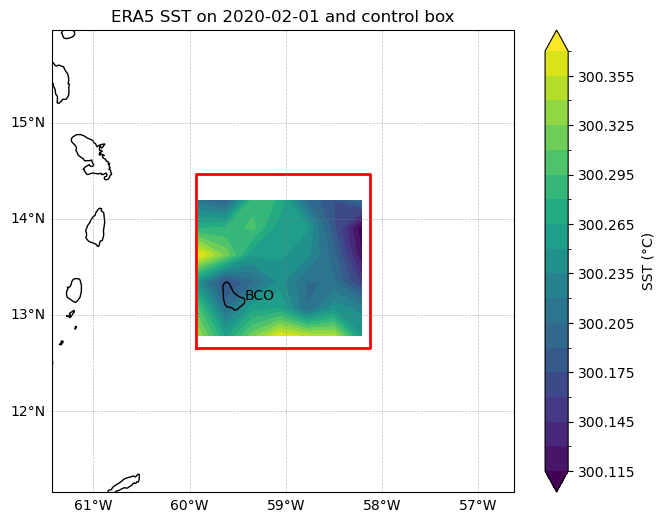

In [23]:


# - presenting area of interest

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([vol_lon[0] - 1.5, vol_lon[1] + 1.5, vol_lat[0] - 1.5, vol_lat[1] + 1.5], crs=ccrs.PlateCarree())

# Draw the rectangle (as a closed polygon)
lons = [vol_lon[0], vol_lon[1], vol_lon[1], vol_lon[0], vol_lon[0]]
lats = [vol_lat[0], vol_lat[0], vol_lat[1], vol_lat[1], vol_lat[0]]
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.PlateCarree())


era5_sst.isel(time=0).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    levels=20,
    robust=True,
    cbar_kwargs={'label': 'SST (°C)'}
)

ax.text(BCO_lon, BCO_lat, "BCO")

gl = ax.gridlines(draw_labels=True, 
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Turn on labels on bottom and left only
gl.top_labels = False
gl.right_labels = False

# Optionally format ticks (degrees + symbols)
gl.xformatter = cticker.LongitudeFormatter()
gl.yformatter = cticker.LatitudeFormatter()

ax.set_title(f"ERA5 SST on {era5_sst.time.values[0].astype('datetime64[D]')} and control box")

## -- open atmospheric variables

In [8]:
import intake 
cat = intake.open_catalog("https://gitlab.dkrz.de/data-infrastructure-services/era5-kerchunks/-/raw/main/main.yaml")
list(cat)

era5 = cat["pressure-level_analysis_daily"].to_dask()
era5

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 70TB
Dimensions:  (time: 30955, level: 37, cell: 542080)
Coordinates:
  * time     (time) datetime64[ns] 248kB 1940-01-01T11:30:00 ... 2024-09-30T1...
  * level    (level) int64 296B 1 2 3 5 7 10 20 ... 850 875 900 925 950 975 1000
    lat      (cell) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
    lon      (cell) float64 4MB dask.array<chunksize=(542080,), meta=np.ndarray>
Dimensions without coordinates: cell
Data variables: (12/14)
    ciwc     (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    crwc     (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    cswc     (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    d        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    o3       (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    pv       (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    ...       ...
    t        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    u        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    v        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    vo       (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    w        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
    z        (time, level, cell) float64 5TB dask.array<chunksize=(5, 5, 542080), meta=np.ndarray>
Attributes: (12/22)
    project:              ECMWF Re-Analysis
    project_id:           ERA
    institution_id:       ECMWF-DKRZ
    institution:          Data from European Centre for Medium-Range Weather ...
    source_id:            IFS
    source:               ECMWF Integrated Forecast System (IFS) CY41R2
    ...                   ...
    format:               kerchunk
    product:              reanalysis
    responsible_persons:  Angelika Heil, Fabian Wachsmann
    title:                The DKRZ ERA5 data pool. Generated using Copernicus...
    license:              The ERA5 data are published with the Copernicus Pro...
    references:           Hersbach, H., Bell, B., Berrisford, P., Hirahara, S...

In [26]:
mask = ((era5.lon >= vol_lon[0]) & (era5.lon <= vol_lon[1]) &
        (era5.lat >= vol_lat[0]) & (era5.lat <= vol_lat[1])).compute()

cell_indices = np.where(mask)[0]
era5 = era5.isel(cell=cell_indices)
era5 = era5.sel(time=slice('2020-02-01','2020-02-18'))

#### add wind vectors for panel meeting

Text(0.5, 1.0, 'ERA5 - SST and wind on 2020-02-01 in control box')

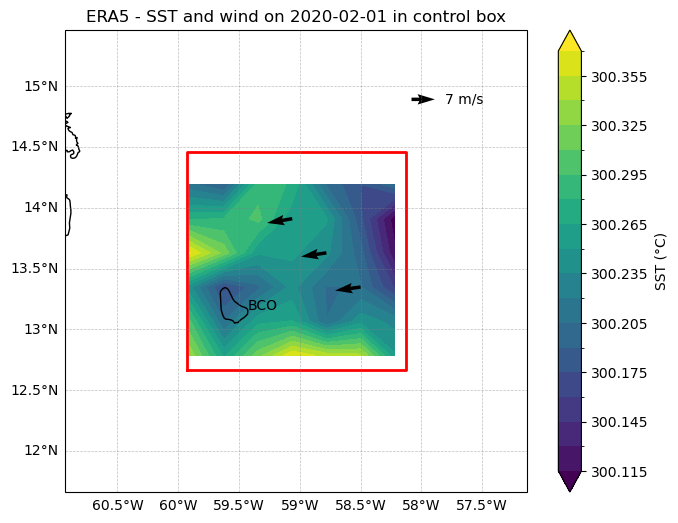

In [33]:


# - presenting area of interest

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add base features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([vol_lon[0] - 1., vol_lon[1] + 1., vol_lat[0] - 1., vol_lat[1] + 1.], crs=ccrs.PlateCarree())

# Draw the rectangle (as a closed polygon)
lons = [vol_lon[0], vol_lon[1], vol_lon[1], vol_lon[0], vol_lon[0]]
lats = [vol_lat[0], vol_lat[0], vol_lat[1], vol_lat[1], vol_lat[0]]
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.PlateCarree())


era5_sst.isel(time=0).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    levels=20,
    robust=True,
    cbar_kwargs={'label': 'SST (°C)'}
)

ax.text(BCO_lon, BCO_lat, "BCO")


### plot wind
quiver_lon = [era5.lon[10], era5.lon[18], era5.lon[26]]
quiver_lat = [era5.lat[10], era5.lat[18], era5.lat[26]]

quiver_u = era5["u"][0, -1, [10, 18, 26]]
quiver_v = era5["v"][0, -1, [10, 18, 26]]

q = ax.quiver(
    quiver_lon, quiver_lat,
    quiver_u, quiver_v,
    transform=ccrs.PlateCarree(),
    color="black"
)

# --- Add scale arrow ---
ax.quiverkey(
    q,
    X=0.8, Y=0.85,          # position in axes coordinates
    U=7,                    # vector length represented (e.g., 5 m/s)
    label="7 m/s",          # label with units
    labelpos="E"
)


gl = ax.gridlines(draw_labels=True, 
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Turn on labels on bottom and left only
gl.top_labels = False
gl.right_labels = False

# Optionally format ticks (degrees + symbols)
gl.xformatter = cticker.LongitudeFormatter()
gl.yformatter = cticker.LatitudeFormatter()

ax.set_title(f"ERA5 - SST and wind on {era5_sst.time.values[0].astype('datetime64[D]')} in control box")

In [28]:
wind_mag = ((era5["u"][0,-1]**2 + era5["v"][0,-1]**2)**0.5).mean(dim="cell").values
wind_mag

array(7.78102209)

Text(-59.4288, 13.1627, 'BCO')

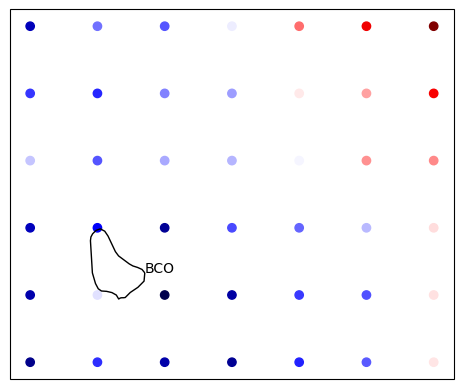

In [10]:
# - time selection
time_sel = slice('2020-02-01', '2020-02-29')

era5_div = era5["d"].sel(time=time_sel) 
era5_w   = era5["w"].sel(time=time_sel) 

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.scatter(era5.lon, era5.lat, c=era5_div.sel(time='2020-02-01', level=400), transform=ccrs.Geodetic(), cmap="seismic")
ax.coastlines()


ax.text(BCO_lon, BCO_lat, "BCO")

In [6]:
# - staggered mid-levels
level_mid = 0.5 * (era5_div.level + era5_div.level.shift(level=-1)).isel(level=slice(None, -1))
level_mid = level_mid.rename({"level": "level_mid"})

# - staggered divergence
stagg_div = 0.5 * (era5_div + era5_div.shift(level=-1))
stagg_div = stagg_div.isel(level=slice(None, -1))
stagg_div = stagg_div.rename({"level": "level_mid"}).assign_coords(level_mid=level_mid)

# - vertical layer thickness in Pa or meters
dp = - era5_div.level.diff("level")  # length matches stagg_div
stagg_div = stagg_div.transpose("time", "cell", "level_mid")
dw = stagg_div * (100) * dp.data
stagg_div = stagg_div.transpose("time", "level_mid", "cell")

# - vertical integration from surface w0
w0 = (era5_w.sel(level=1000) + era5_w.sel(level=975))*0.5
w = w0 + dw.cumsum(dim="level_mid")
w = w.transpose("time", "level_mid", "cell")

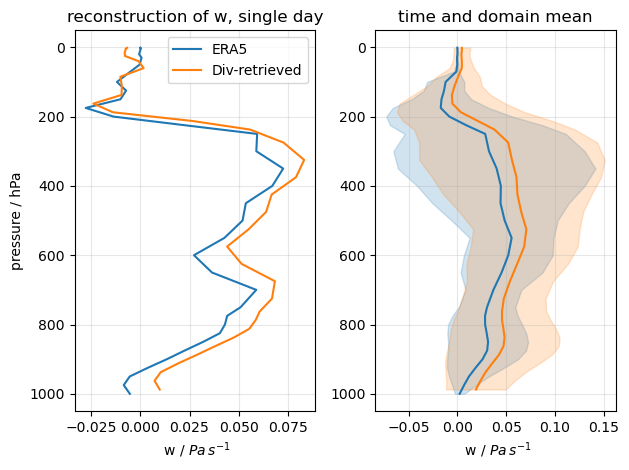

In [12]:
w_dom_mean         = era5_w.mean(dim="cell")
w_fromDiv_dom_mean = w.mean(dim="cell")

fig, ax = plt.subplots(1,2)

i = int(0)
ax[0].plot(w_dom_mean[i], w_dom_mean.level, label="ERA5")
ax[0].plot(w_fromDiv_dom_mean[i], w_fromDiv_dom_mean.level_mid, label="Div-retrieved")
ax[0].invert_yaxis()
ax[0].legend()

ax[0].set_title(f"reconstruction of w, single day")
ax[0].set_xlabel(r" w / $Pa\,s^{-1}$")
ax[0].set_ylabel("pressure / hPa")
ax[0].grid('major', alpha=0.3)


# - compare time mean
ax[1].invert_yaxis()
ax[1].plot(w_dom_mean.mean(dim="time"), w_dom_mean.level, color="tab:blue")
ax[1].fill_betweenx(w_dom_mean.level,
                     w_dom_mean.mean(dim="time") - w_dom_mean.std(dim="time"), 
                     w_dom_mean.mean(dim="time") + w_dom_mean.std(dim="time"), alpha=0.2, label='±1 std', color="tab:blue")

ax[1].plot(w_fromDiv_dom_mean.mean(dim="time"), w_fromDiv_dom_mean.level_mid, color="tab:orange")
ax[1].fill_betweenx(w_fromDiv_dom_mean.level_mid,
                     w_fromDiv_dom_mean.mean(dim="time") - w_fromDiv_dom_mean.std(dim="time"), 
                     w_fromDiv_dom_mean.mean(dim="time") + w_fromDiv_dom_mean.std(dim="time"), alpha=0.2, label='±1 std', color="tab:orange")



ax[1].set_title(f"time and domain mean")
ax[1].set_xlabel(r" w / $Pa\,s^{-1}$")
ax[1].grid('major', alpha=0.3)


plt.tight_layout()

In [8]:
def build_shading_plot(x, y, dim, ax=None):
    color = input("color line? ")

    import matplotlib.pyplot as plt

    y_mean = y.mean(dim=dim, skipna=True)
    yerr   = y.std(dim=dim, skipna=True)

    if ax is None:
        plt.plot(x, y_mean, color=color)
        plt.fill_between(x, y_mean - yerr, y_mean + yerr, alpha=0.2, label='±1 std', color=color)
    else:
        ax.plot(x, y_mean, color=color)
        ax.fill_between(x, y - yerr, y + yerr, alpha=0.2, label='±1 std')
    

